<center>
    <p align="center">
        <img src="https://logodownload.org/wp-content/uploads/2017/09/mackenzie-logo-3.png" style="height: 7ch;"><br>
        <h1 align="center">Computer Systems Undergradute Thesis</h1>
        <h2 align="center">Quantitative Analysis of the Impact of Image Pre-Processing on the Accuracy of Computer Vision Models Trained to Identify Dermatological Skin Diseases</a>
        <h4 align="center">Gabriel Mitelman Tkacz</a>
        </h4>
    </p>
</center>

<hr>

In [1]:
from functools import partial
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tomllib
import torch
from pynimbar import loading_animation

from util import (
    DenoiseTransform,
    EqualizationTransform,
    NormalizeTransform,
    evaluate_model,
    get_model_data,
)

In [2]:
with open("parameters.toml", "r") as f:
    parameters = tomllib.loads(f.read())

loading_handler = partial(
    loading_animation, break_on_error=True, verbose_errors=True, time_it_live=True
)

alpha = chr(0x03B1)

pprint(parameters)

{'PREPROCESS': {'denoise': {'search_window_size': 19,
                            'template_window_size': 5},
                'normalize': {'mean': 0.4, 'std': 0.2}},
 'TRAINING': {'batch_size': 128,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'learning_rate': 0.0001,
              'num_epochs': 3,
              'num_workers': 12,
              'pin_memory': True,
              'precision_threshold': 0.8,
              'resize_dim': 128,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
training_ratio = parameters["TRAINING"]["training_dataset_ratio"]
testing_ratio = validation_ratio = round(1 - training_ratio, 1) / 2

print(f"Training ratio: {training_ratio*100}%")
print(f"Testing ratio: {testing_ratio*100}%")
print(f"Validation ratio: {validation_ratio*100}%")

seed = 47
print(f"\nSeed: {seed}")

Training ratio: 80.0%
Testing ratio: 10.0%
Validation ratio: 10.0%

Seed: 47


## Class 0 Model: Images with no pre-processing

In [5]:
(
    base_train_loader,
    base_test_loader,
    base_validation_loader,
) = get_model_data(
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

base_precision = evaluate_model(
    device, base_train_loader, base_test_loader, base_validation_loader
)

print(f"Base precision: {base_precision*100:.2f}%")

if base_precision < parameters["TRAINING"]["precision_threshold"]:
    raise ValueError("The base model did not meet the precision threshold.")

Epoch 1/3, Train Loss: 0.0807, Train Accuracy: 89.44%, Validation Loss: 0.2306, Validation Accuracy: 49.00%
Best model at epoch 1 with Validation Accuracy: 49.00%
Epoch 2/3, Train Loss: 0.0364, Train Accuracy: 95.31%, Validation Loss: 0.1139, Validation Accuracy: 87.00%
Best model at epoch 2 with Validation Accuracy: 87.00%
Epoch 3/3, Train Loss: 0.0294, Train Accuracy: 96.06%, Validation Loss: 0.0678, Validation Accuracy: 89.50%
Best model at epoch 3 with Validation Accuracy: 89.50%
Total training duration: 3.31 minutes
Test Accuracy of the Binary Classification Model: 89.50%
Base precision: 89.50%


## Class 1 Models: Images with only one pre-process

### Class 1.1 Models: Normalizing the image

In [6]:
(
    normalize_train_loader,
    normalize_test_loader,
    normalize_validation_loader,
) = get_model_data(
    [NormalizeTransform(**parameters["PREPROCESS"]["normalize"])],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

normalize_precision = evaluate_model(
    device, normalize_train_loader, normalize_test_loader, normalize_validation_loader
)

normalize_precision_diff = normalize_precision - base_precision

print(f"\n\nNormalized precision: {normalize_precision*100:.2f}%")
print(
    f"That is an {'upgrade' if normalize_precision_diff > 0 else 'downgrade'} of {normalize_precision_diff*100:.2f}%."
)

Epoch 1/3, Train Loss: 0.0747, Train Accuracy: 90.56%, Validation Loss: 0.1327, Validation Accuracy: 88.00%
Best model at epoch 1 with Validation Accuracy: 88.00%
Epoch 2/3, Train Loss: 0.0309, Train Accuracy: 96.12%, Validation Loss: 0.0286, Validation Accuracy: 97.00%
Best model at epoch 2 with Validation Accuracy: 97.00%
Epoch 3/3, Train Loss: 0.0264, Train Accuracy: 96.62%, Validation Loss: 0.0242, Validation Accuracy: 97.00%
Total training duration: 3.11 minutes
Test Accuracy of the Binary Classification Model: 95.50%


Normalized precision: 95.50%
That is an upgrade of 6.00%.


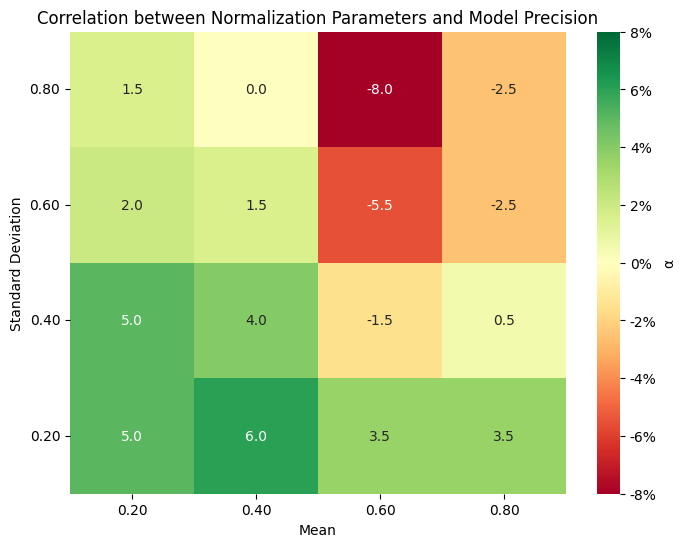

In [21]:
df = pd.read_json("./params/normalize.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.pivot(index="std", columns="mean", values="precision")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
    pivot_table_pct,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": alpha, "format": "%.0f%%"},
    vmin=-vabs,
    vmax=vabs
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_xticklabels([f"{x:.2f}" for x in pivot_table_pct.columns])
plt.gca().set_yticklabels([f"{y:.2f}" for y in pivot_table_pct.index])

plt.title("Correlation between Normalization Parameters and Model Precision")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")

plt.show()

### Class 1.2 Models: Denoising the image

In [11]:
(
    denoise_train_loader,
    denoise_test_loader,
    denoise_validation_loader,
) = get_model_data(
    [DenoiseTransform(**parameters["PREPROCESS"]["denoise"])],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

denoise_precision = evaluate_model(
    device, denoise_train_loader, denoise_test_loader, denoise_validation_loader
)

denoise_precision_diff = denoise_precision - base_precision

print(f"\n\nDenoised precision: {denoise_precision*100:.2f}%")
print(
    f"That is an {'upgrade' if denoise_precision_diff > 0 else 'downgrade'} of {denoise_precision_diff*100:.2f}%."
)

Epoch 1/3, Train Loss: 0.0865, Train Accuracy: 88.25%, Validation Loss: 0.2458, Validation Accuracy: 48.50%
Best model at epoch 1 with Validation Accuracy: 48.50%
Epoch 2/3, Train Loss: 0.0392, Train Accuracy: 95.06%, Validation Loss: 0.2288, Validation Accuracy: 56.50%
Best model at epoch 2 with Validation Accuracy: 56.50%
Epoch 3/3, Train Loss: 0.0387, Train Accuracy: 94.75%, Validation Loss: 0.0307, Validation Accuracy: 96.50%
Best model at epoch 3 with Validation Accuracy: 96.50%
Total training duration: 4.73 minutes
Test Accuracy of the Binary Classification Model: 94.00%


Denoised precision: 94.00%
That is an upgrade of 4.50%.


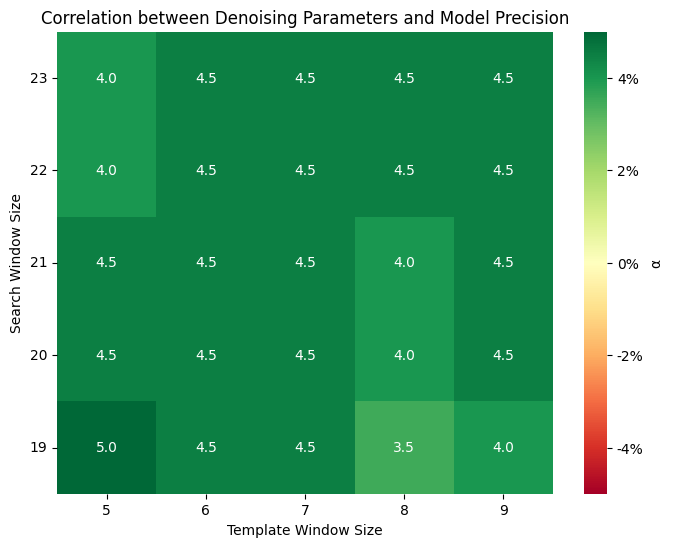

In [20]:
df = pd.read_json("./params/denoise.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.pivot(index="search_window_size", columns="template_window_size", values="precision")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
    pivot_table_pct,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": alpha, "format": "%.0f%%"},
    vmin=-vabs,
    vmax=vabs
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_xticklabels([f"{x:.0f}" for x in pivot_table_pct.columns])
plt.gca().set_yticklabels([f"{y:.0f}" for y in pivot_table_pct.index])

plt.title("Correlation between Denoising Parameters and Model Precision")
plt.xlabel('Template Window Size')
plt.ylabel('Search Window Size')

plt.show()

### Class 1.3 Models: Equalizing the image

In [7]:
(
    denoise_train_loader,
    denoise_test_loader,
    denoise_validation_loader,
) = get_model_data(
    [EqualizationTransform()],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

denoise_precision = evaluate_model(
    device, denoise_train_loader, denoise_test_loader, denoise_validation_loader
)

denoise_precision_diff = denoise_precision - base_precision

print(f"\n\nDenoised precision: {denoise_precision*100:.2f}%")
print(
    f"That is an {'upgrade' if denoise_precision_diff > 0 else 'downgrade'} of {denoise_precision_diff*100:.2f}%."
)

Epoch 1/3, Train Loss: 0.0802, Train Accuracy: 89.25%, Validation Loss: 0.3328, Validation Accuracy: 48.50%
Best model at epoch 1 with Validation Accuracy: 48.50%
Epoch 2/3, Train Loss: 0.0243, Train Accuracy: 96.94%, Validation Loss: 0.2212, Validation Accuracy: 64.00%
Best model at epoch 2 with Validation Accuracy: 64.00%
Epoch 3/3, Train Loss: 0.0304, Train Accuracy: 96.00%, Validation Loss: 0.0461, Validation Accuracy: 95.50%
Best model at epoch 3 with Validation Accuracy: 95.50%
Total training duration: 3.16 minutes
Test Accuracy of the Binary Classification Model: 94.50%


Denoised precision: 94.50%
That is an upgrade of 5.00%.
